In [25]:
import pandas as pd
import numpy as np
from prophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# 1. Build synthetic sales history
def make_synthetic_sales(start_date="2023-01-01", days=365, products=None, seed=42):
    np.random.seed(seed)
    if products is None:
        products = ["P01", "P02", "P03"]
    dates = pd.date_range(start=start_date, periods=days, freq="D")
    records = []
    for pid in products:
        base = np.random.uniform(20, 50)  # avg level
        weekly = 10 * np.sin(2 * np.pi * dates.dayofweek / 7)  # weekly seasonality
        noise = np.random.normal(0, 5, size=len(dates))  # gaussian noise
        vals = pd.Series(base + weekly + noise, index=dates)  # combine
        sales = vals.clip(lower=0).round().astype(int)  # no negatives
        df = pd.DataFrame({
            "ds": dates,
            "product_id": pid,
            "y": sales.values
        })
        records.append(df)
    return pd.concat(records, ignore_index=True)


sales = make_synthetic_sales()


In [27]:
# 2. Forecast next 30 days per product & slice only that window
forecast_horizon = 30
all_fcsts = []
for pid, grp in sales.groupby("product_id"):
    m = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False)
    m.fit(grp[["ds", "y"]])
    future = m.make_future_dataframe(periods=forecast_horizon, freq="D")
    fcst   = m.predict(future)

    # take only the last `forecast_horizon` days for this product
    fcst_30 = (
        fcst[["ds", "yhat"]]
        .iloc[-forecast_horizon:]
        .copy()
    )
    fcst_30["product_id"] = pid
    all_fcsts.append(fcst_30)

forecast_30d = pd.concat(all_fcsts, ignore_index=True)

22:18:39 - cmdstanpy - INFO - Chain [1] start processing
22:18:39 - cmdstanpy - INFO - Chain [1] done processing
22:18:39 - cmdstanpy - INFO - Chain [1] start processing
22:18:39 - cmdstanpy - INFO - Chain [1] done processing
22:18:40 - cmdstanpy - INFO - Chain [1] start processing
22:18:40 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# 3. Generate synthetic inventory data
inv = pd.DataFrame({
    "product_id": sales["product_id"].unique(),
    "current_stock": np.random.randint(30, 80, size=len(sales["product_id"].unique())),
    "safety_stock":  np.random.randint(10, 25, size=len(sales["product_id"].unique()))
})

In [29]:
# 4. Compute suggested restock quantities
restock = (
    forecast_30d
    .groupby("product_id")["yhat"]
    .sum()
    .reset_index()
    .rename(columns={"yhat": "forecasted_demand_30d"})
)
restock = restock.merge(inv, on="product_id", how="left")
restock["suggested_restock"] = (
    restock["forecasted_demand_30d"]
    - (restock["current_stock"] - restock["safety_stock"])
).clip(lower=0).astype(str)

In [30]:
# 5. Save or inspect
restock.to_csv("restock_suggestions.csv", index=False)
print(restock)


  product_id  forecasted_demand_30d  current_stock  safety_stock  \
0        P01            1008.318286             74            18   
1        P02             657.993924             40            22   
2        P03             819.332719             57            19   

   suggested_restock  
0  952.3182858351456  
1  639.9939240463035  
2  781.3327190382217  


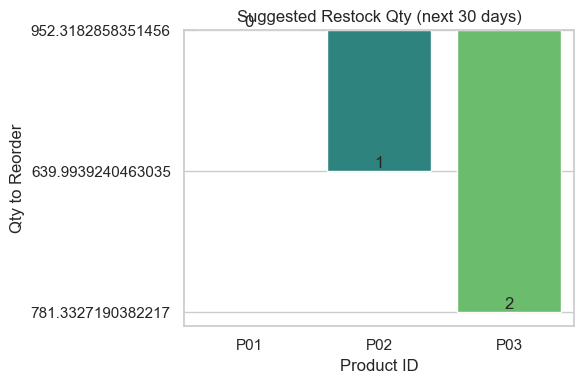

In [31]:

# 6. Plot with Seaborn (no warning)
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=restock,
    x="product_id",
    y="suggested_restock",
    hue="product_id",
    palette="viridis",
    dodge=False
)
# ax.legend_.remove()
ax.set_title("Suggested Restock Qty (next 30 days)")
ax.set_xlabel("Product ID")
ax.set_ylabel("Qty to Reorder")

for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center", va="bottom"
    )

plt.tight_layout()
plt.show()